In [90]:
import json
import math
from os import listdir
import sys
import re
import gensim
import time
import datetime
from collections import Counter
from sklearn.naive_bayes import GaussianNB


import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# load word embedding trained from Tweetdata and Generaldata
emb = gensim.models.KeyedVectors.load_word2vec_format('Set8_TweetDataWithoutSpam_GeneralData_Word_Phrase.bin', binary=True)

In [3]:
# make source tweets' ID a list for train, development and test data
trainFile = './rumoureval-2019-training-data/train-key.json'
f = json.load(open(trainFile, 'r'))
trainSourceTweet = list(f['subtaskbenglish'].keys())  ###################### only source tweets
allTrainID = list(f['subtaskaenglish'].keys()) ###################### tweets ID including source tweets and replies
trainLabels = f['subtaskbenglish']
tweets_stances_train = f['subtaskaenglish'] ################## train and dev data are using same datasets

devFile = './rumoureval-2019-training-data/dev-key.json'
f = json.load(open(devFile, 'r'))
devSourceTweet = list(f['subtaskbenglish'].keys())   ######################  only source tweets
allDevID = list(f['subtaskaenglish'].keys())      ######################  tweets ID including source tweets and replies
devLabels = f['subtaskbenglish']
tweets_stances_dev = f['subtaskaenglish'] ################## train and dev data are using same datasets

testFile = './final-eval-key.json'
f = json.load(open(testFile, 'r'))
testSourceTweet = list(f['subtaskbenglish'].keys())  ###################### only source tweets
allTestID = list(f['subtaskaenglish'].keys())     ################### tweets ID including source tweets and replies
testLabels = f['subtaskbenglish']
tweets_stances_test = f['subtaskaenglish'] ################## train and dev data are using same datasets

In [4]:
trainDocPath = './rumoureval-2019-training-data/twitter-english'
trainDocList = listdir(trainDocPath)  # each element in doclist is a topic ['charliehebdo','ferguson'...]
devDocPath = trainDocPath # dev and train dataset are in the same directory
devDocList = trainDocList

testDocPath = './rumoureval-2019-test-data/twitter-en-test-data'
testDocList = listdir(testDocPath)

In [5]:
trainDocList

['charliehebdo',
 'ebola-essien',
 'ferguson',
 'germanwings-crash',
 'illary',
 'ottawashooting',
 'prince-toronto',
 'putinmissing',
 'sydneysiege']

In [5]:
def getStructure(sourceTweets,filePath):
#@@ Param:  
#Source_tweets: a list of source tweets ID
#filePath: source tweets  parent document directory
#@@ Return: 
#structures:an tree stucture , each root is a source tweet ID, values are tweets replying to the parent node
    
    structures ={}
    docs = listdir(filePath)
    
    for tweetID in sourceTweets:
        for i in range(len(docs)):
            IDs = listdir(filePath+'/'+docs[i])
            if tweetID in IDs:
                tmp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/structure.json','r'))
                structures[tweetID] = tmp[tweetID]
               
    return structures

In [6]:
trainStructure = getStructure(trainSourceTweet ,trainDocPath)  # length: 297
devStructure = getStructure(devSourceTweet ,devDocPath) # length: 28
testStructure = getStructure(testSourceTweet ,testDocPath) # length: 56

In [7]:
def trTraverse(struct, node, path = []):
    
    global trBranches
    
    path.append(node)
    if struct[node] == []:
        trBranches += [path.copy()]
        path.pop()
    else:
        struct = struct[node]
        for child in struct:
            trTraverse(struct, child, path) 
        path.pop()

def devTraverse(struct, node, path = []):
    
    global devBranches
    
    path.append(node)
    if struct[node] == []:
        devBranches += [path.copy()]
        path.pop()
    else:
        struct = struct[node]
        for child in struct:
            devTraverse(struct, child, path) 
        path.pop()

def teTraverse(struct, node, path = []):
    
    global teBranches
    
    path.append(node)
    if struct[node] == []:
        teBranches += [path.copy()]
        path.pop()
    else:
        struct = struct[node]
        for child in struct:
            teTraverse(struct, child, path) 
        path.pop()


In [8]:
tree = []

def iterTree(struct,node):
    
    global tree
    tree += [node]
   
    if struct[node] == []:
        pass
    else:
        struct_new = struct[node]
        for child in struct_new:
            iterTree(struct_new, child)      


In [9]:
trBranches = [] ####################### lists of branches
devBranches = [] #######################
teBranches = [] #######################

for item in trainStructure:   ###################################
    tree = []
    iterTree(trainStructure, item)
    trBranches += [tree]

for item in devStructure:
    tree = []
    iterTree(devStructure, item)
    devBranches += [tree]

for item in testStructure:
    tree = []
    iterTree(testStructure, item)
    teBranches += [tree]

In [11]:
print(len(trBranches))
print(len(devBranches))
print(len(teBranches))

297
28
56


In [10]:
def extractAllFeatures(filePath):
#@@ Param:  
# filePath:  tweets  parent document directory
#@@ Return: 
# tweetTEUE: an dictionary, which the key: Values is tweetID : {}(json)， including source tweets and reply tweets
    
    tweetTEUE = {}
    docs = listdir(filePath)
    
    for i in range(len(docs)):
        IDs = listdir(filePath+'/'+docs[i])
        for tweetID in IDs:
            
            sourceTemp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/source-tweet/'+tweetID+'.json','r'))
            tweetTEUE[tweetID] = sourceTemp
            
            replyIDs = listdir(filePath+'/'+docs[i]+'/'+tweetID+'/replies')
            replyIDs = [jsonFile.replace('.json','') for jsonFile in replyIDs]
            for ID in replyIDs:
                replyTemp = json.load(open(filePath+'/'+docs[i]+'/'+tweetID+'/replies/'+ID+'.json','r'))
                tweetTEUE[ID] = replyTemp

    return tweetTEUE

In [11]:
tweetID2AllFeatures = extractAllFeatures(trainDocPath)

testAllFeatures = extractAllFeatures(testDocPath)

In [12]:
def getText(idList, featureList): # get texts and respoding ID from source tweets
    
    text = []
    IDs = []
    for ID in idList:
        text += [featureList[ID]['text']]
        IDs += [ID]
        
    return text,IDs       

In [13]:
trainText, trainID = getText(allTrainID, tweetID2AllFeatures) ######################################
devText, devID = getText(allDevID, tweetID2AllFeatures) #################################
testText, testID = getText(allTestID, testAllFeatures) ######################################

In [14]:
allText = trainText + devText + testText 
allID = trainID + devID + testID

Json file explanation for twitter: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object

In [15]:
f = open('./files/dict_branch.txt','r')
f = f.read()
word2id = eval(f) ###############################

In [16]:
id2word = dict([val, key] for key, val in word2id.items()) ##############################################

In [17]:
def readFile(filePath):

    with open(filePath,'r') as f:
        s = f.readlines()
  
    for i in range(len(s)):
        s[i] = s[i].replace('\n','')

    return s

In [18]:
all_word_text = readFile('./files/all_token_list_branch.txt')

In [21]:
all_word_text ############################### text data after data washing

['this shows michael paid for cigarillos no robbery no crime pls rt ',
 'get ready to tweet the address #spikelee and other vigilantes ',
 'your radical muslims are being funded by american senate israel and saudia arabia ',
 'just kill them ',
 'no because that would require reasoning and then if reasoning is applied no one can be shot shoot now reason later ',
 'au gov and tony abbott is responsible for this mess au gov created the rebels frankenstein in syria ',
 'u know theres some fucked up people who wants to see him blow up himself ',
 'why would the ferguson pd and stlco pd release the information they ve released and fail to mention that ',
 'here are pixs i have ',
 '',
 'yeah posting information about an evolving shooter situation is less worthwhile than an untrained journalist performing cpr ',
 'no he hasn t ',
 'hunt them down like the animals that they are ',
 'thank you ',
 'which accounts ',
 'reason forthis massacre is a concrete action of paper not general principles

In [19]:
def tokenizeText(x_raw):

    x = x_raw.split(' ')
    x.remove('')

    return x

In [20]:
X_token = [tokenizeText(x) for x in all_word_text] ################################ into token

In [21]:
def toNumSeq(X_raw,vocab):
  
    doc = []
  
    for text in X_raw:
        numSeq = []
        for wrd in text:
            if wrd in vocab:
                numSeq += [vocab[wrd]]
            else:
                numSeq += [vocab['<OOV>']]
        doc += [numSeq]
  
    return doc


In [22]:
X_all = toNumSeq(X_token,word2id)############## num of sequence

In [23]:
print(X_all[200])
print(X_token[200])
print(id2word[939])
print(id2word[5208])
print(word2id['put'])

[939, 5208, 5395, 4928, 6884, 7252, 5152, 6340, 3002, 2748, 4752, 7956, 3877, 4816, 7992, 1331, 2492, 5377]
['put', 'the', 'geoblock', 'back', 'on', 'we', 'can', 'have', 'coverage', 'once', 'they', 're', 'out', 'don', 't', 'broadcast', 'police', 'movements']
put
the
939


In [24]:
embedding_matrix = np.zeros((len(word2id)+1,300))
for word, i in word2id.items():
    if word in emb:
        embedding_vector = emb[word]
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)


In [25]:
id2word[8168]

'<OOV>'

In [26]:
len(embedding_matrix)

8169

In [27]:
def num2vec(X_num, embedding):
  
    vec_list = []
    for x in X_num:
        vec = []
        for num in x:
            vec += [embedding[num]]
        vec_list += [vec]
  
    return vec_list

In [28]:
X_vec = num2vec(X_all, embedding_matrix)

In [29]:
# this is the code to turn all-zeros vectors in X_vec into average vectors 
for i in range(len(X_vec)):
    for j in range(len(X_vec[i])):
        if np.all(X_vec[i][j]==0):
            X_vec[i][j] = sum(X_vec[i])/len(X_vec[i])

In [30]:
X_rep = np.zeros((len(X_vec),300)) ####################################

for i in range(len(X_vec)): 
    if X_vec[i]!=[]: # some tweets only contains mentions and url that were removed, so in X_vec, there are some [] array
        X_rep[i] = sum(X_vec[i])/len(X_vec[i])

In [31]:
def getExistence(source_tweets, ID2Data):
#@@ Param:  Source_tweets: a list of source tweets ID
#           filePath: source tweets  parent document directory
#@@ Return: an n x 2 array, n is the amount/number of source tweets' IDs    
    
    existence = np.zeros((len(source_tweets),2))
    for i in range(len(source_tweets)):
        data = ID2Data[source_tweets[i]]
        if len(data['entities']['hashtags']) != 0:
            existence[i][0] = 1
        else:
            existence[i][0] = 0
        
        if len(data['entities']['urls']) != 0:
            existence[i][1] = 1
        else:
            existence[i][1] = 0
            
    return existence


# extract features, Percentage of replying tweets classified as queries, denies or supports
def getPercentage(threads, tweets_stances):
#@@ Param: source_tweets: a list of source tweets ID
#          tweets_stances：a list of stances, which contains all tweets' stance including reply tweets and source tweets
#          filePath: source tweets  parent document directory
#@@ Return: an n x 3 array, n is the amount/number of source tweets' IDs
   
    stance_list = []
    for thread in threads:
        tmp = []
        for i in range(1,len(thread)):
            if thread[i] in tweets_stances:
                tmp += [tweets_stances[thread[i]]]
        stance_list += [tmp]
    
    
    stance_percentage = np.zeros((len(stance_list),3)) # initialise an array, column 0,1,2 are percentages of query, deny, support
    
    for i in range(len(stance_list)):
        count = Counter(stance_list[i])
        l = len(stance_list[i])
        if 'query' in count:
            stance_percentage[i][0] = count['query']/l
        else:
            stance_percentage[i][0] = 0 
        
        if 'deny' in count:
            stance_percentage[i][1] = count['deny']/l
        else:
            stance_percentage[i][1] = 0 
        
        if 'support' in count:
            stance_percentage[i][2] = count['support']/l
        else:
            stance_percentage[i][2] = 0 
    
    return stance_percentage

In [32]:
def getUserInfo(tweetsID,featureList,files):
    
    userFeatures = []
    for i in range(len(tweetsID)):
        data = files[tweetsID[i]]
        userData = [data['user'][feature] for feature in featureList]
        userData += [data['created_at']]
        userFeatures += [userData]
    
    return userFeatures
  

def transferUserInfo(userInfo):
    results = np.zeros((len(userInfo),len(userInfo[0])-1),dtype=int)
    for i in range(len(userInfo)):
        #if it has been verified
        if userInfo[i][0]==False:
            results[i][0] = 0
        else:
            results[i][0] = 1
        
        #if it has location?               
        if userInfo[i][1]=='' or userInfo[i][1]==None:
            results[i][1] = 0
        else:
            results[i][1] = 1
            
        #if it has description?
        if userInfo[i][2]=='' or userInfo[i][2]==None:
            results[i][2] = 0
        else:
            results[i][2] = 1

        #how many followers?
        results[i][3] = userInfo[i][3]               
        #how many people it follows?
        results[i][4] = userInfo[i][4]
        #how many tweets it posted?
        results[i][5] = userInfo[i][5]               
        #how many days, after creating this account, when he/she posted this tweet
        tp = time.strptime(userInfo[i][-1],"%a %b %d %H:%M:%S %z %Y")
        tc = time.strptime(userInfo[i][-2],"%a %b %d %H:%M:%S %z %Y")
        diff = (datetime.datetime(tp.tm_year, tp.tm_mon, tp.tm_mday) - datetime.datetime(tc.tm_year, tc.tm_mon, tc.tm_mday)).days
        results[i][6] = diff
        
    return results

In [36]:
tweets_stances_train

{'501760642928635904': 'comment',
 '500270212198174720': 'comment',
 '524971210275565568': 'comment',
 '552836882770690049': 'comment',
 '500289931097296897': 'support',
 '544293230649810944': 'comment',
 '544283032732332032': 'comment',
 '500406679176241153': 'comment',
 '500300182844878848': 'comment',
 '552811591683821568': 'comment',
 '524938343180931073': 'comment',
 '521360786409943041': 'deny',
 '524946532416884736': 'comment',
 '544347456238931968': 'comment',
 '525020658972258305': 'query',
 '552817834628501505': 'comment',
 '524959078229880832': 'comment',
 '553588165408473088': 'comment',
 '544293748377518080': 'comment',
 '553196346375954433': 'query',
 '524957146656821249': 'comment',
 '524992668301262848': 'deny',
 '500294827351621632': 'comment',
 '544307827070615553': 'support',
 '524955418955902976': 'comment',
 '553541495588802560': 'comment',
 '500301494193627136': 'comment',
 '525026551411519488': 'comment',
 '553565149790224387': 'comment',
 '544520601038098433': '

In [33]:
X_source_tr = [trBranches[i][0] for i in range(len(trBranches))]
X_source_dev = [devBranches[i][0] for i in range(len(devBranches))]
X_source_te = [teBranches[i][0] for i in range(len(teBranches))]

In [34]:
existence_tr = getExistence(X_source_tr, tweetID2AllFeatures)
qds_percentage_tr = getPercentage(trBranches, tweets_stances_train)

existence_dev = getExistence(X_source_dev, tweetID2AllFeatures)
qds_percentage_dev = getPercentage(devBranches, tweets_stances_dev)

existence_te = getExistence(X_source_te, testAllFeatures)
qds_percentage_te = getPercentage(teBranches, tweets_stances_test)



In [39]:
features = ['verified', 'location', 'description', 'followers_count', 'friends_count', 'statuses_count', "favourites_count",'created_at']

userInfoString_tr = getUserInfo(X_source_tr,features,tweetID2AllFeatures)
ue_tr = transferUserInfo(userInfoString_tr)

userInfoString_dev = getUserInfo(X_source_dev,features,tweetID2AllFeatures)
ue_dev = transferUserInfo(userInfoString_dev)

userInfoString_te = getUserInfo(X_source_te,features,testAllFeatures)
ue_te = transferUserInfo(userInfoString_te)

In [40]:
############## scaling user info

scaler = preprocessing.StandardScaler().fit(ue_tr) 
ue_tr = scaler.transform(ue_tr)

ue_dev = scaler.transform(ue_dev)

ue_te = scaler.transform(ue_te)

In [36]:
X_rep_tr, X_rep_dev, X_rep_te = X_rep[:len(allTrainID)], X_rep[len(allTrainID):(len(allTrainID)+len(allDevID))], X_rep[(len(allTrainID)+len(allDevID)):(len(allTrainID)+len(allDevID)+len(allTestID))]
print(len(X_rep_tr),'+',len(X_rep_dev),'+',len(X_rep_te),'=',len(X_rep_tr)+len(X_rep_dev)+len(X_rep_te)) ################ check their length
#print(len(ue_tr),'+',len(ue_dev),'+',len(ue_te),'=',len(ue_tr)+len(ue_dev)+len(ue_te))

4519 + 1049 + 1066 = 6634


In [37]:
tr_ID2X = dict(zip(allTrainID,X_rep_tr)) #######################################
dev_ID2X = dict(zip(allDevID,X_rep_dev)) #################################### 
te_ID2X = dict(zip(allTestID,X_rep_te)) ###################################

In [43]:
# trBranches 
# devBranches 
# teBranches 

In [38]:
def getInput(X_tree,ID2X): # average all tweets representation 
    
    X = []
    
    for thread in X_tree:
        X_tmp = []
        for ID in thread:
            if ID in ID2X:
                X_tmp += [ID2X[ID]]
        X += [sum(X_tmp)/len(X_tmp)]
    
    return X

In [39]:
X_tr = getInput(trBranches, tr_ID2X) ########################
X_dev = getInput(devBranches, dev_ID2X) ########################
X_te = getInput(teBranches, te_ID2X) #########################

In [40]:
#transfer label
def str2no(y_string):
#@@ Param: a list of rumour veracity labels, each element is a string
#@@ Return: a list of label, each element is an int; 0,1,2 represent 'unverified','false','true' respectively
    
    y = []
    for cls in y_string:
        if cls=='unverified':
            y += [0]
        elif cls=='false':
            y += [1]
        elif cls=='true':
            y += [2]
    return y

In [41]:
X_tr = np.array(X_tr) #############################
X_dev = np.array(X_dev)#############################
X_te = np.array(X_te)############################

In [63]:
X_tr = np.hstack((np.hstack((np.hstack((existence_tr,qds_percentage_tr)),ue_tr)),X_tr))
X_dev = np.hstack((np.hstack((np.hstack((existence_dev,qds_percentage_dev)),ue_dev)),X_dev))
X_te = np.hstack((np.hstack((np.hstack((existence_te,qds_percentage_te)),ue_te)),X_te))

In [42]:
X_tr.shape

(297, 300)

In [43]:
Y_tr = [trainLabels[trBranches[i][0]] for i in range(len(trBranches))]
Y_dev = [devLabels[devBranches[i][0]] for i in range(len(devBranches))] 
Y_te = [testLabels[teBranches[i][0]] for i in range(len(teBranches))] 

In [44]:
y_tr = np.array(str2no(Y_tr)) ###########################
y_dev = np.array(str2no(Y_dev)) ##########################
y_te = np.array(str2no(Y_te)) ##########################

In [80]:
clf = svm.LinearSVC(multi_class='ovr', C=300, max_iter=100000)
clf.fit(X=X_tr, y=y_tr)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

CalibratedClassifierCV(base_estimator=LinearSVC(C=300, max_iter=100000),
                       cv='prefit')

In [81]:
sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

In [82]:
y_hat

array([2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1])

In [83]:
clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2

In [84]:
y_hat ###################### after processing, y_hat should only contains 2 classes

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1])

In [85]:
def scorer(y_truth, y_hat, confidence): # rumourEval 2019 version of scorer
#@ Param:  y_truth: a list of true labels
#          y_hat: a list of predicted y values
#          confidence: a list of confidence values related to y_hat
# Return: accuracy score, RMSE and Macro averaged F1 score
    
    correct = 0
    total = len(y_hat)
    errors = []
    y_pred = []
    
    for i in range(total):
        if confidence[i]>0.5:
                y_pred += [y_hat[i]]
        else:
                y_pred += [0]   
        
        if y_pred[i] == y_truth[i] and y_truth[i]!=0:
            correct += 1
            errors += [(1-confidence[i])**2]

        elif y_truth[i] == 0:
            errors += [ (confidence[i])**2 ]

        else:
            errors += [1.0]
    
    score = correct / total
    rmse = math.sqrt( sum(errors) / len(errors) )
    macroF = f1_score(y_truth, y_pred, average='macro')

    return score,rmse,macroF

In [86]:
score,rmse,macroF = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.375
RMSE: 0.799142353908347
Macro averaged F1 socre: 0.28125


In [108]:
clf = RandomForestClassifier(n_estimators=1600)
clf.fit(X=X_tr, y=y_tr)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2

score,rmse,macroF = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.4107142857142857
RMSE: 0.7737898034803257
Macro averaged F1 socre: 0.2905405405405405


In [91]:
clf = GaussianNB()
clf.fit(X=X_tr, y=y_tr)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2

score,rmse,macroF = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.21428571428571427
RMSE: 0.8771085328145903
Macro averaged F1 socre: 0.17139001349527663


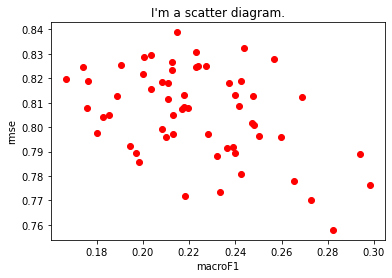

In [106]:
rmse_list = []
macroF_list = []
esnum_list = []

for estimator_num in range(100,6000,100):
    
    clf = RandomForestClassifier(n_estimators=estimator_num)
    clf.fit(X=X_tr, y=y_tr)
    sig_clf = CalibratedClassifierCV(clf,method='isotonic', cv='prefit')
    sig_clf.fit(X_dev,y_dev)
    
    sig_clf_probs = sig_clf.predict_proba(X_te) 

    y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

    clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

    for i in range(len(y_hat)):
        if y_hat[i]!=0:
            clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
        else:
            if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
                clf_confidence[i] = sig_clf_probs[i][1]
                y_hat[i] = 1
            else:
                clf_confidence[i] = sig_clf_probs[i][2]
                y_hat[i] = 2
    
    score,rmse,macroF = scorer(y_te,y_hat,clf_confidence)
    
    esnum_list += [estimator_num]
    rmse_list += [rmse]
    macroF_list += [macroF]
    
import matplotlib.pyplot as plt
plt.title("I'm a scatter diagram.") 
# plt.xlim(xmax=7,xmin=0)
# plt.ylim(ymax=7,ymin=0)
plt.plot(macroF_list,rmse_list,'ro')
plt.xlabel("macroF1")
plt.ylabel("rmse")
plt.show()



In [107]:
esnum_list[rmse_list.index(min(rmse_list))]

1600